# Testing feasibility loss metrics on empirical ecosystems

In [1]:
import numpy as np
import pandas as pd
import os
import time
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import networkx as nx
import pygraphviz
from scipy.stats import linregress

### Parameterizing the networks and saving them

Parameterize the networks in different ways and then save them to analyze later. You might skip this cell if you already parametrized them. You might choose to do the analysis on the smaller networks or all of them by setting the input_dir. Large networks takes considerably a lot longer to run.

In [ ]:
INPUT_DIR = 'web-of-life_2025/' # This is the dataset of adjacency networks obtained from web of life
OUTPUT_DIR = 'parameterized_networks_local_stable' # Analysis saves them in this file but I named the final results differently to not to override them and to separate two different webs.
X_MIN, X_MAX = 9, 11
DRIFT_MEAN, DRIFT_STD = 1.0, 0.1
BASELINE_GAMMA = 0.25

# We do separate parametrizations for mutualistic networks than food webs
PARAM_CONFIGS_MUTUALISTIC = [
    {'scale_factor': 0.40, 'c': 0.5}, #low mean, low variance
    {'scale_factor': 0.80, 'c': 0.5},
    {'scale_factor': 0.40, 'c': 2.0},
    {'scale_factor': 0.80, 'c': 2.0}
]

# Parameter configurations for food web and antagonistic webs
PARAM_CONFIGS_FW_A = [
    {'mu_ratio': 0.5, 'c': 0.5}, 
    {'mu_ratio': 2.0, 'c': 0.5},
    {'mu_ratio': 0.5, 'c': 2.0},
    {'mu_ratio': 2.0, 'c': 2.0}
]

DEFAULT_SCALE_FACTOR = 0.75
CONSERVATIVE_SCALE_FACTOR = 0.25

def get_interaction_scale_mu(A_template):
    # This finds a reasonable interaction strength mean for between group values
    # based on the core interaction value to create a local stable system
    try:
        max_eig = np.max(np.abs(np.linalg.eigvals(A_template)))
    except np.linalg.LinAlgError: return 0
    if max_eig<= 1e-15: return np.inf
    return 1.0 / max_eig

def parameterize_and_save_networks():
    # Reads the networks files and applies appropriate parametrization that will
    # also guarantee local stability

    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    try:
        network_files = [f for f in os.listdir(INPUT_DIR) if f.endswith('.csv')]
    except FileNotFoundError:
        print(f"Error: Input directory '{INPUT_DIR}' not found")
        return
    
    print(f"Found {len(network_files)} networks. Starting the parametrization")

    # Main loop to iterate through each file once.
    for file_name in network_files:
        file_path = os.path.join(INPUT_DIR, file_name)
        L = pd.read_csv(file_path, header= None).astype(float).to_numpy()

        #Determine the configuration to be used for the given network
        if file_name.startswith('M_'):
            configs_to_run = PARAM_CONFIGS_MUTUALISTIC
            network_type = 'Mutualistic'
        elif file_name.startswith(('A_', 'FW_')):
            configs_to_run = PARAM_CONFIGS_FW_A
            network_type = 'Antagonistic/FW'
        else:
            continue

        print(f"\n Processing {file_name} ({network_type})")

        # Inner loop for the configuration specific to this type of network
        for config in configs_to_run:
            c = config['c']
            coeff_var = np.sqrt(c)

            # Set parameters and scale factors
            if network_type == 'Mutualistic':
                scale_factors_to_try = [config['scale_factor']]
                mu_ratio = 1.0 # This is default essentially not used at all
                print(f"Running with config: scale_factor={config['scale_factor']}, c={c}")
            else: #in case the network is either FW or A
                scale_factors_to_try = [DEFAULT_SCALE_FACTOR, CONSERVATIVE_SCALE_FACTOR]
                mu_ratio = config['mu_ratio']
                print(f"Running with config: mu_ratio={mu_ratio}, c={c}")
            
            stability_achieved = False

            # This loop tries the scale factors for the networks to see which one will be stable
            # For M it will run once but for A/FW it can run two times if necessary
            for attempt, scale_factor in enumerate(scale_factors_to_try):
                n_rows, n_cols = L.shape
                # Building the template matrix A_template
                if network_type == 'Mutualistic' or file_name.startswith('A_'):
                    S = n_rows + n_cols
                    A_template = np.zeros((S,S))
                    if network_type == 'Mutualistic':
                        A_template[:n_rows, n_rows:] = L
                        A_template[n_rows:, :n_rows] = L.T
                    else: #Antagonistic
                        A_template[:n_rows, n_rows:] = L * (-mu_ratio)
                        A_template[n_rows:, :n_rows] = L.T
                elif file_name.startswith('FW_'): # Food web
                    S = n_rows if n_rows == n_cols else n_rows + n_cols
                    if n_rows == n_cols:
                        A_template = L.T + (L * (-mu_ratio))
                    else:
                        A_template = np.zeros((S,S))
                        A_template[n_rows:, :n_rows] = L.T
                        A_template[:n_rows, n_rows:] = L * (-mu_ratio)

                # Build the interaction matrix (A_partial)
                mu_max = get_interaction_scale_mu(A_template)
                mu_plus = scale_factor * mu_max if not np.isinf(mu_max) else 1.0
                mu_minus = -mu_ratio * mu_plus
                sigma_pos = abs(mu_plus) * coeff_var
                sigma_neg = (abs(mu_minus)) * coeff_var
                A_partial = np.zeros((S, S))

                if file_name.startswith('M_'):
                    A_partial[:n_rows, n_rows:] = L * np.random.normal(loc=mu_plus, scale = sigma_pos, size = L.shape)
                    A_partial[n_rows:, :n_rows] = L.T * np.random.normal(loc=mu_plus, scale = sigma_pos, size = L.T.shape)
                elif file_name.startswith('A_'):
                    A_partial[:n_rows, n_rows:] = L * np.random.normal(loc=mu_minus, scale = sigma_neg, size = L.shape)
                    A_partial[n_rows:, :n_rows] = L.T * np.random.normal(loc=mu_plus, scale = sigma_pos, size = L.T.shape)        
                elif file_name.startswith('FW_'):
                    if n_rows == n_cols:
                        A_partial = (L.T * np.random.normal(loc = mu_plus, scale=sigma_pos, size=(S,S))) + \
                        (L * np.random.normal(loc = mu_minus, scale=sigma_neg, size=(S,S)))
                    else:
                        A_partial[n_rows:, :n_rows] = L.T * np.random.normal(loc=mu_plus, scale=sigma_pos, size=L.T.shape)
                        A_partial[:n_rows, n_rows:] = L * np.random.normal(loc=mu_minus, scale=sigma_neg, size=L.shape)  
                np.fill_diagonal(A_partial, -1.0)

                # Iteratively find in group interactions gamma and enforce stability
                initial_max_real = np.max(np.real(np.linalg.eigvals(A_partial)))
                gamma = max(initial_max_real + 0.01, BASELINE_GAMMA) if initial_max_real >= 0 else BASELINE_GAMMA

                competition_template = np.zeros_like(A_partial)
                if network_type in ['Mutualistic', 'Antagonistic/FW'] and (n_rows != n_cols or file_name.startswith('A_')):
                    competition_template[:n_rows, :n_rows] = 1 - np.eye(n_rows)
                    competition_template[n_rows:, n_rows:] = 1 - np.eye(n_cols)

                max_iter, iter_count = 100, 0

                #Local stability criteria
                # while iter_count < max_iter:
                #     A_final = A_partial - (gamma*competition_template)
                #     if np.max(np.real(np.linalg.eigvals(A_final))) < 0:
                #         stability_achieved = True
                #         break
                #     gamma += 0.05
                #     iter_count += 1

                #Global stability criteria
                while iter_count < max_iter:
                    A_final = A_partial - (gamma*competition_template)
                    if np.max(np.real(np.linalg.eigvals(A_final + A_final.T))) < 0:
                        stability_achieved = True
                        break
                    gamma += 0.05
                    iter_count += 1

                if stability_achieved:
                    print(f" -> Stability success: S={S}, mu+={mu_plus:.2f}, scale={scale_factor}, final_gamma={gamma:.4f}, iters={iter_count}")
                    break
                elif attempt == 0 and len(scale_factors_to_try) > 1:
                    print(f" -> Attempt 1 failed. Trying to weaken the positive relationships")
            if not stability_achieved:
                print(f" -> Warning: Stability not reached for this config. Skipping.")
                continue
            
            # Save the results
            x_equilibrium = np.random.uniform(low=X_MIN, high=X_MAX, size=S)
            r_growth_rates = -A_final@x_equilibrium
            k_drift = np.random.normal(loc=DRIFT_MEAN, scale=DRIFT_STD, size=(S,S))
            base_name = os.path.splitext(file_name)[0]

            # Create filename based on the config type
            if network_type == 'Mutualistic':
                sf = config['scale_factor']
                output_filename = f"{base_name}_sf{sf}_c{c}.npz"

            else: # For Antagonistic/FW networks
                mr = config['mu_ratio']
                # The 'scale_factor' variable now holds the value that succeeded
                sf_used = scale_factor 
                # RECOMMENDED CHANGE: Add the successful scale_factor to the filename
                output_filename = f"{base_name}_mur{mr}_c{c}_sf{sf_used:.2f}.npz"

            
            output_path = os.path.join(OUTPUT_DIR, output_filename)
            np.savez(output_path, interaction_matrix_A0=A_final, equilibrium_x = x_equilibrium, growth_rates_r = r_growth_rates, drift_matrix_k = k_drift)
    print(f"\nProcessing complete")

if __name__ == '__main__':
    parameterize_and_save_networks()
                    

Found 29 networks. Starting the parametrization

 Processing M_PL_046.csv (Mutualistic)
Running with config: scale_factor=0.4, c=0.5
 -> Stability success: S=60, mu+=0.03, scale=0.4, final_gamma=0.2500, iters=0
Running with config: scale_factor=0.8, c=0.5
 -> Stability success: S=60, mu+=0.06, scale=0.8, final_gamma=0.2500, iters=0
Running with config: scale_factor=0.4, c=2.0
 -> Stability success: S=60, mu+=0.03, scale=0.4, final_gamma=0.2500, iters=0
Running with config: scale_factor=0.8, c=2.0
 -> Stability success: S=60, mu+=0.06, scale=0.8, final_gamma=0.2500, iters=0

 Processing M_PL_052.csv (Mutualistic)
Running with config: scale_factor=0.4, c=0.5
 -> Stability success: S=54, mu+=0.07, scale=0.4, final_gamma=0.2500, iters=0
Running with config: scale_factor=0.8, c=0.5
 -> Stability success: S=54, mu+=0.13, scale=0.8, final_gamma=0.2500, iters=0
Running with config: scale_factor=0.4, c=2.0
 -> Stability success: S=54, mu+=0.07, scale=0.4, final_gamma=0.2500, iters=0
Running wit

### Find optimal diffusion rates (noise) to be used in simulations and carry out the simulations

Make sure to choose a sensible diffusion rate such that mean time to feasibility loss is neither too small or too large. You can skip this cell if you already obtained the simulation results (cell takes at least couple hours to run on all of the networks)

In [ ]:
# Latest version of the cell that calibrates diffusion constant the best
#Simulation Parameters
PARAM_DIR = 'parameterized_networks_local_stable/' #Edit this file to write the simulation results on top
N_SIMULATIONS_FULL = 1000     # Number of runs for the final statistics
T_MAX = 2000                  # Maximum number of time steps per simulation
DT = 0.01                     # Time step size
TARGET_TIME_RANGE = (T_MAX * DT * 0.1, T_MAX * DT * 0.5) 

def calculate_analytical_predictions(A0, x_equilibrium, k_drift, calibrated_c):
    """Calculates analytical predictions using NumPy."""
    S = A0.shape[0]
    D_diffusion = (calibrated_c * np.abs(A0))
    sigma_A_sq = D_diffusion / (2 * (k_drift + 1e-30))
    try:
        A0_inv = np.linalg.inv(A0)
    except np.linalg.LinAlgError:
        return np.nan, np.full(S, np.nan), np.full(S, np.nan)
    S_tensor = -np.einsum('mp,q->mpq', A0_inv, x_equilibrium)
    escape_rates = []
    for k_idx in range(S):
        S_k = S_tensor[k_idx, :, :]
        sigma_k_sq = np.sum((S_k**2) * sigma_A_sq)
        if sigma_k_sq < 1e-30:
            escape_rates.append(0.0)
            continue
        sigma_k = np.sqrt(sigma_k_sq)
        numerator_gamma_k = np.sum((S_k**2) * k_drift * sigma_A_sq)
        gamma_k = numerator_gamma_k / sigma_k_sq
        x0_k = x_equilibrium[k_idx]
        try:
            log_prefactor = np.log(gamma_k * x0_k) - np.log(sigma_k * np.sqrt(2 * np.pi))
            barrier = (x0_k**2) / (2 * sigma_k_sq)
            lambda_k = np.exp(log_prefactor - barrier)
        except (ValueError, OverflowError):
            lambda_k = 0.0
        escape_rates.append(lambda_k)
    escape_rates = np.array(escape_rates)
    lambda_eff = np.sum(escape_rates)
    T_loss_analytical = 1.0 / lambda_eff if lambda_eff > 1e-300 else np.inf
    escape_ratios = escape_rates / lambda_eff if lambda_eff > 1e-300 else np.zeros(S)
    return T_loss_analytical, escape_rates, escape_ratios

def run_simulation_batch(n_runs, c_diffusion, A0, r_growth, k_drift):
    """
    Runs a batch of simulations and returns means and standard errors.
    """
    S = A0.shape[0]
    D_diffusion = (c_diffusion * np.abs(A0))
    loss_times = []
    first_loss_species = []
    for _ in range(n_runs):
        delta_A = np.zeros_like(A0)
        for t_step in range(T_MAX):
            if t_step > 0:
                noise_term = np.sqrt(D_diffusion * DT) * np.random.normal(size=A0.shape)
                delta_A += -k_drift * delta_A * DT + noise_term
            
            A_t = A0 + delta_A
            try:
                y_equilibrium = np.linalg.solve(A_t, -r_growth)
                if np.any(y_equilibrium <= 0):
                    loss_times.append(t_step * DT)
                    lost_species_indices = np.where(y_equilibrium <= 0)[0]

                    #first_loss_species.append(lost_species_indices[0]) # If more than one species goes below zero, take the one with lower index

                    most_lost_idx = y_equilibrium[lost_species_indices].argmin() # If more than one species goes below zero, take the one that is lower in value
                    first_loss_species.append(lost_species_indices[most_lost_idx])

                    #first_loss_species.append(np.random.choice(lost_species_indices)) # If more than one species goes below zero, choose one of them randomly
                    
                    break
            except np.linalg.LinAlgError:
                loss_times.append(t_step * DT)
                first_loss_species.append(-1)
                break
        else:
            loss_times.append(T_MAX * DT)
            
    mean_loss_time = np.mean(loss_times)
    sem_loss_time = np.std(loss_times, ddof=1) / np.sqrt(n_runs) if n_runs > 1 else 0

    loss_counts = np.zeros(S, dtype=int)
    unique, counts = np.unique(first_loss_species, return_counts=True)
    for species_idx, count in zip(unique, counts):
        if species_idx != -1:
            loss_counts[species_idx] = count
            
    total_losses = np.sum(loss_counts)
    loss_frequencies = loss_counts / total_losses if total_losses > 0 else np.zeros(S)
    se_loss_frequencies = np.sqrt(loss_frequencies * (1 - loss_frequencies) / total_losses) if total_losses > 1 else np.zeros(S)
    
    return mean_loss_time, sem_loss_time, loss_counts, loss_frequencies, se_loss_frequencies

def calibrate_diffusion_constant(A0, x_equilibrium, k_drift):
    """
    Calibrates diffusion constant `c` to achieve a random target analytical time
    using a numerical root-finder with a robust objective function.
    """
    print("    > Calibrating diffusion constant for a random target...")
    
    target_T_loss = np.random.uniform(TARGET_TIME_RANGE[0], TARGET_TIME_RANGE[1])
    print(f"      Targeting analytical T_loss = {target_T_loss:.2f}")

    # robust objective function
    def objective_function(c):
        t_loss, _, _ = calculate_analytical_predictions(A0, x_equilibrium, k_drift, c)
        if np.isinf(t_loss):
            # This occurs when c is too small, making T_loss huge.
            # The function value should be large and positive.
            return 1e12
        if np.isnan(t_loss):
            # This often occurs when c is too large, causing numerical errors.
            # T_loss is effectively zero, so the function value should be negative.
            return -1e12
        return t_loss - target_T_loss

    # Find a search bracket [c_low, c_high] where the objective function crosses zero
    c_low, c_high = 1e-6, 1.0
    
    expand_attempts = 0
    while objective_function(c_high) > 0 and expand_attempts < 15:
        c_high *= 2.0
        expand_attempts += 1
    if objective_function(c_high) > 0:
        print("      ! Could not find an upper bound for c. Calibration failed.")
        return None

    # Use the robust Brent's method to find the optimal c
    try:
        calibrated_c = brentq(objective_function, c_low, c_high, xtol=1e-5, rtol=1e-5)
        print(f"    > Calibration successful. Using c = {calibrated_c:.4f}")
        return calibrated_c
    except ValueError:
        print("      ! Root finding failed. The signs at the bracket endpoints are not different.")
        return None

#Main execution block for simulations
if __name__ == '__main__':
    param_files = [f for f in os.listdir(PARAM_DIR) if f.endswith('.npz')]
    print(f"Starting simulations for {len(param_files)} networks...")
    start_time_total = time.time()
    for i, file_name in enumerate(param_files):
        print(f"\n({i+1}/{len(param_files)}) Processing {file_name}...")
        file_path = os.path.join(PARAM_DIR, file_name)
        data = np.load(file_path, allow_pickle=True)
        
        if 'mean_loss_time' in data:
            print("    > Simulation results already exist. Skipping.")
            continue
            
        A0 = data['interaction_matrix_A0']
        x_eq = data['equilibrium_x']
        r_growth = data['growth_rates_r']
        k_drift = data['drift_matrix_k']
        
        calibrated_c = calibrate_diffusion_constant(A0, x_eq, k_drift)
        
        if calibrated_c is None:
            print("    > Skipping simulation due to failed calibration.")
            continue
        
        print(f"    > Running full simulation with {N_SIMULATIONS_FULL} runs...")
        start_sim_time = time.time()
        mean_time, sem_time, loss_cnts, loss_freqs, se_freqs = run_simulation_batch(N_SIMULATIONS_FULL, calibrated_c, A0, r_growth, k_drift)
        end_sim_time = time.time()
        print(f"    > Simulation finished in {end_sim_time - start_sim_time:.2f}s. Mean Loss Time = {mean_time:.2f} +/- {sem_time:.2f}")

        T_loss, rates, ratios = calculate_analytical_predictions(A0, x_eq, k_drift, calibrated_c)
        print(f"    > Final Analytical T_loss = {T_loss:.2f}")

        all_data = dict(data)
        all_data['calibrated_diffusion_c'] = calibrated_c
        all_data['mean_loss_time'] = mean_time
        all_data['sem_loss_time'] = sem_time
        all_data['loss_counts'] = loss_cnts
        all_data['loss_frequencies'] = loss_freqs
        all_data['se_loss_frequencies'] = se_freqs
        all_data['analytical_T_loss'] = T_loss
        all_data['analytical_escape_rates'] = rates
        all_data['analytical_escape_ratios'] = ratios
        
        np.savez(file_path, **all_data)
        print(f"    > Results appended and saved to {file_name}")

    end_time_total = time.time()
    print(f"\n\nAll simulations complete. Total time: {end_time_total - start_time_total:.2f} seconds.")


Starting simulations for 262 networks...

(1/262) Processing M_PL_011_sf0.4_c2.0.npz...
    > Simulation results already exist. Skipping.

(2/262) Processing M_SD_015_sf0.4_c2.0.npz...
    > Simulation results already exist. Skipping.

(3/262) Processing FW_012_02_mur2.0_c2.0_sf0.75.npz...
    > Simulation results already exist. Skipping.

(4/262) Processing M_SD_017_sf0.8_c2.0.npz...
    > Simulation results already exist. Skipping.

(5/262) Processing A_PH_004_mur0.5_c0.5_sf0.75.npz...
    > Simulation results already exist. Skipping.

(6/262) Processing M_SD_013_sf0.4_c0.5.npz...
    > Simulation results already exist. Skipping.

(7/262) Processing M_PL_008_sf0.8_c0.5.npz...
    > Simulation results already exist. Skipping.

(8/262) Processing M_PL_010_sf0.4_c0.5.npz...
    > Simulation results already exist. Skipping.

(9/262) Processing M_PL_012_sf0.8_c0.5.npz...
    > Simulation results already exist. Skipping.

(10/262) Processing A_PH_005_mur2.0_c2.0_sf0.75.npz...
    > Simulat

Function to calculate concordance correlation coefficient on simulation results

In [11]:
def concordance_correlation_coefficient(y_true, y_pred):
    "Calculates Lin's Concordance Correlation Coefficient."
    cor = np.corrcoef(y_true, y_pred)[0][1]
    mean_true, var_true, sd_true = np.mean(y_true), np.var(y_true), np.std(y_true)
    mean_pred, var_pred, sd_pred = np.mean(y_pred), np.var(y_pred), np.std(y_pred)
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

### Analyze results on figures of escape rates and mean time to feasibility loss

Plot saved as persistence_time_comparison_M.png


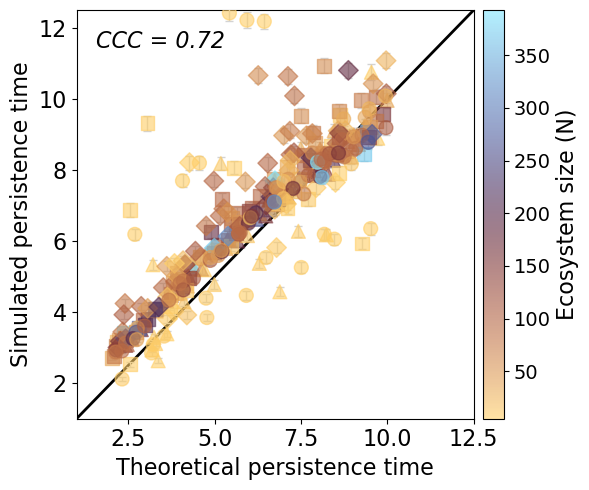

In [ ]:
# Directory where the result files are saved
PARAM_DIR = 'parameterized_networks_local_stable_M_1.3/' # I named the networks that I analyzed differently to separate food webs with mutualistic ones and not to override the final results

def create_persistence_plot(data_points, output_filename="persistence_time_comparison_M.png"):
    """
    Creates a scatter plot with error bars comparing analytical vs. simulated persistence times,
    using different markers for each parameter configuration.
    """
    if not data_points:
        print("No data to plot for persistence time comparison.")
        return

    fig, ax = plt.subplots(figsize=(6, 5))
    
    markers = {
        'sf0.2_c0.5': ('o', r'Weak mutualism,' +'\n' + 'low variance'),
        'sf0.6_c0.5': ('s', r'Strong mutualism,' +'\n' + 'low variance'),
        'sf0.2_c2.0': ('^', r'Weak mutualism,' +'\n' + 'high variance'),
        'sf0.6_c2.0': ('D', r'Strong mutualism,' +'\n' + 'high variance')
    }

    plot_lim_min = 1.0
    plot_lim_max = 12.5
    
    ax.set_xlim(plot_lim_min, plot_lim_max)
    ax.set_ylim(plot_lim_min, plot_lim_max)
    ax.plot([plot_lim_min, plot_lim_max], [plot_lim_min, plot_lim_max], 
            color='black', linestyle='-', linewidth=2.0, zorder=1)
    
    #Aggregate all data points for statistical analysis
    all_analytical = np.concatenate([d['analytical'] for d in data_points.values()])
    all_simulated = np.concatenate([d['simulated'] for d in data_points.values()])

    # Perform all statistical analyses
    if len(all_analytical) > 1:
        slope, intercept, r_value, _, _ = linregress(all_analytical, all_simulated)
        r_squared = r_value**2
        rmse = np.sqrt(np.mean((all_simulated - all_analytical)**2))
        # ---Calculate Concordance Correlation Coefficient ---
        ccc = concordance_correlation_coefficient(all_simulated, all_analytical)
    else:
        slope, intercept, r_squared, rmse, ccc = (np.nan,) * 5

    all_sizes = np.concatenate([d['sizes'] for d in data_points.values()])
    norm = plt.Normalize(vmin=np.min(all_sizes), vmax=np.max(all_sizes))

    all_sizes = np.concatenate([d['sizes'] for d in data_points.values()])
    norm = plt.Normalize(vmin=np.min(all_sizes), vmax=np.max(all_sizes))

    #Plot the actual data, but without labels
    for config_key, data in data_points.items():
        marker_shape, label = markers.get(config_key, ('x', config_key))
        
        ax.errorbar(
            data['analytical'], 
            data['simulated'], 
            yerr=data['sem'],
            fmt='none',
            ecolor='lightgray',
            elinewidth=1,
            capsize=3,
            zorder=5 
        )
        
        #label=None prevents this from being used in the legend
        scatter = ax.scatter(
            data['analytical'], 
            data['simulated'], 
            c=data['sizes'], 
            cmap='managua', # Corrected typo
            marker=marker_shape,
            label=None, # Important: No label here
            s=100, 
            alpha=0.6, 
            norm=norm,
            zorder=10
        )
        
    # create dummy plots for the legend
    # We plot invisible data points with the desired solid black markers and labels
    for config_key in markers:
        marker_shape, label = markers[config_key]
        ax.plot([], [], # Empty data
                marker=marker_shape,
                color='black',
                linestyle='None',
                markersize=8,
                label=label)

    cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label("Ecosystem size (N)", fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_xlabel("Theoretical persistence time", fontsize=16)
    ax.set_ylabel("Simulated persistence time", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

    #Create the legend from our dummy plots
    # The 'facecolor="black"' argument you had sets the legend box background, not the markers.
    #ax.legend(fontsize=14, frameon=False, labelspacing=0.5, handletextpad=0.1, loc="lower right")

    # ---statistical results box ---
    # stats_text = (f"y = {slope:.2f}x + {intercept:.2f}\n"
    #               f"$R^2$ = {r_squared:.2f} | RMSE = {rmse:.2f}\n"
    #               f"CCC = {ccc:.2f}")
    stats_text = (f"CCC = {ccc:.2f}")
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', fontweight='normal', fontstyle='oblique', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.0))

    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Plot saved as {output_filename}")
    plt.show()

#Main execution block
if __name__ == '__main__':
    data_points = {}
    
    param_files = [f for f in os.listdir(PARAM_DIR) if f.endswith('.npz')]
    
    for file_name in param_files:
        #Correctly parse the config key from the filename
        parts = file_name.replace('.npz', '').split('_')
        sf_part = next((p for p in parts if p.startswith('sf')), None)
        c_part = next((p for p in parts if p.startswith('c')), None)

        if sf_part is None or c_part is None:
            continue
        
        config_key = f"{sf_part}_{c_part}"

        file_path = os.path.join(PARAM_DIR, file_name)
        data = np.load(file_path, allow_pickle=True)
        
        required_keys = ['analytical_T_loss', 'mean_loss_time', 'sem_loss_time', 'interaction_matrix_A0']
        if not all(key in data for key in required_keys):
            continue

        if config_key not in data_points:
            data_points[config_key] = {'analytical': [], 'simulated': [], 'sem': [], 'sizes': []}

        data_points[config_key]['analytical'].append(data['analytical_T_loss'])
        data_points[config_key]['simulated'].append(data['mean_loss_time'])
        data_points[config_key]['sem'].append(data['sem_loss_time'])
        data_points[config_key]['sizes'].append(data['interaction_matrix_A0'].shape[0])

    for config in data_points:
        for key in data_points[config]:
            data_points[config][key] = np.array(data_points[config][key])

    create_persistence_plot(data_points)

Plot saved as persistence_time_comparison_FW.png


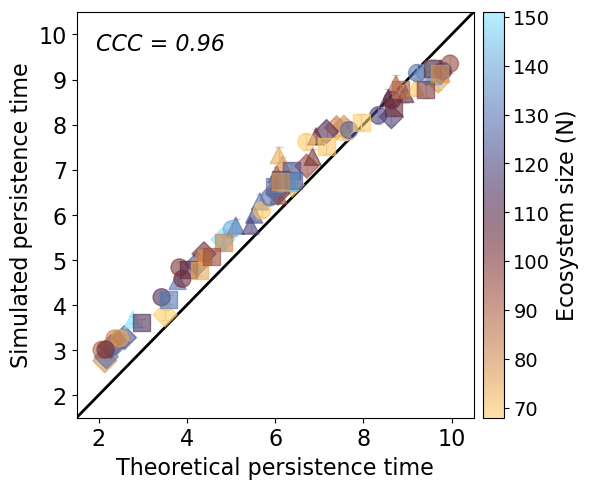

In [12]:
# Directory where the result files are saved
PARAM_DIR = 'parameterized_networks_local_stable_FW_1.3'

def create_persistence_plot(data_points, output_filename="persistence_time_comparison_FW.png"):
    """
    Creates a scatter plot with error bars comparing analytical vs. simulated persistence times,
    using different markers for each parameter configuration.
    """
    if not data_points:
        print("No data to plot for persistence time comparison.")
        return

    fig, ax = plt.subplots(figsize=(6, 5))
    
    markers = {
        'mur0.5_c0.5': ('o', r'Low $\mu_{ratio}$,' +'\n' + 'low variance'),
        'mur2.0_c0.5': ('s', r'High $\mu_{ratio}$,' +'\n' + 'low variance'),
        'mur0.5_c2.0': ('^', r'Low $\mu_{ratio}$,' +'\n' + 'high variance'),
        'mur2.0_c2.0': ('D', r'High $\mu_{ratio}$,' +'\n' + 'high variance')
    }

    plot_lim_min = 1.5
    plot_lim_max = 10.5
    
    ax.set_xlim(plot_lim_min, plot_lim_max)
    ax.set_ylim(plot_lim_min, plot_lim_max)
    ax.plot([plot_lim_min, plot_lim_max], [plot_lim_min, plot_lim_max], 
            color='black', linestyle='-', linewidth=2.0, zorder=1)
    
    #Aggregate all data points for statistical analysis
    all_analytical = np.concatenate([d['analytical'] for d in data_points.values()])
    all_simulated = np.concatenate([d['simulated'] for d in data_points.values()])

    all_sizes = np.concatenate([d['sizes'] for d in data_points.values()])
    norm = plt.Normalize(vmin=np.min(all_sizes), vmax=np.max(all_sizes))

    # Perform all statistical analyses
    if len(all_analytical) > 1:
        slope, intercept, r_value, _, _ = linregress(all_analytical, all_simulated)
        r_squared = r_value**2
        rmse = np.sqrt(np.mean((all_simulated - all_analytical)**2))
        # Calculate Concordance Correlation Coefficient
        ccc = concordance_correlation_coefficient(all_simulated, all_analytical)
    else:
        slope, intercept, r_squared, rmse, ccc = (np.nan,) * 5

    #Plot the actual data, but without labels
    for config_key, data in data_points.items():
        marker_shape, label = markers.get(config_key, ('x', config_key))
        
        ax.errorbar(
            data['analytical'], 
            data['simulated'], 
            yerr=data['sem'],
            fmt='none',
            ecolor='lightgray',
            elinewidth=1,
            capsize=3,
            zorder=5 
        )
        
        #'label=None' prevents this from being used in the legend
        scatter = ax.scatter(
            data['analytical'], 
            data['simulated'], 
            c=data['sizes'], 
            cmap='managua',
            marker=marker_shape,
            label=None,
            s=150, 
            alpha=0.6, 
            norm=norm,
            zorder=10
        )
        
    # Create "dummy" plots just for the legend 
    for config_key in markers:
        marker_shape, label = markers[config_key]
        ax.plot([], [],
                marker=marker_shape,
                color='black',
                linestyle='None',
                markersize=8,
                label=label)

    cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label("Ecosystem size (N)", fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_xlabel("Theoretical persistence time", fontsize=16)
    ax.set_ylabel("Simulated persistence time", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)

    #Create the legend from our dummy plots
    # The 'facecolor="black"' argument you had sets the legend box background, not the markers.
    #ax.legend(fontsize=14, frameon=False, labelspacing=0.5, handletextpad=0.1, loc="lower right")

    #statistical results box
    # stats_text = (f"y = {slope:.2f}x + {intercept:.2f}\n"
    #               f"$R^2$ = {r_squared:.2f} | RMSE = {rmse:.2f}\n"
    #               f"CCC = {ccc:.2f}")
    stats_text = (f"CCC = {ccc:.2f}")
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', fontweight='normal', fontstyle='oblique', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.0))

    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Plot saved as {output_filename}")
    plt.show()

#Main execution
if __name__ == '__main__':
    data_points = {}
    
    param_files = [f for f in os.listdir(PARAM_DIR) if f.endswith('.npz')]
    
    for file_name in param_files:
        #Correctly parse the config key from the filename
        parts = file_name.replace('.npz', '').split('_')
        mu_part = next((p for p in parts if p.startswith('mur')), None)
        c_part = next((p for p in parts if p.startswith('c')), None)

        if mu_part is None or c_part is None:
            continue
        
        config_key = f"{mu_part}_{c_part}"

        file_path = os.path.join(PARAM_DIR, file_name)
        data = np.load(file_path, allow_pickle=True)
        
        required_keys = ['analytical_T_loss', 'mean_loss_time', 'sem_loss_time', 'interaction_matrix_A0']
        if not all(key in data for key in required_keys):
            continue

        if config_key not in data_points:
            data_points[config_key] = {'analytical': [], 'simulated': [], 'sem': [], 'sizes': []}

        data_points[config_key]['analytical'].append(data['analytical_T_loss'])
        data_points[config_key]['simulated'].append(data['mean_loss_time'])
        data_points[config_key]['sem'].append(data['sem_loss_time'])
        data_points[config_key]['sizes'].append(data['interaction_matrix_A0'].shape[0])

    for config in data_points:
        for key in data_points[config]:
            data_points[config][key] = np.array(data_points[config][key])

    create_persistence_plot(data_points)

Plot saved as all_ratios_loglog_comparison_M.png


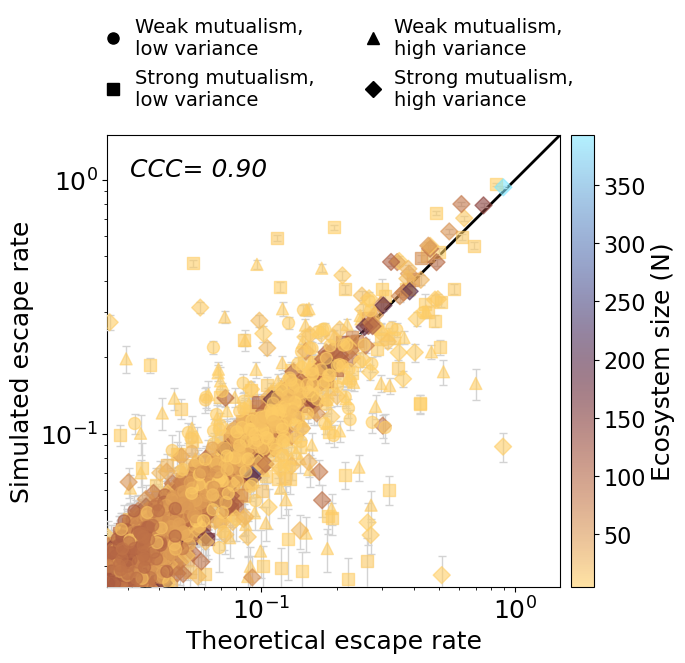

In [13]:
# Directory where the result files are saved
PARAM_DIR = 'parameterized_networks_local_stable_M_1.3/'

#Plotting function to handle different markers
def plot_all_ratios_loglog(data_points, output_filename="all_ratios_loglog_comparison_M.png"):
    """
    Creates a log-log plot with error bars comparing escape rate ratios
    with their corresponding simulated loss ratios, using different markers.
    """
    if not data_points:
        print("No data points met the threshold for plotting.")
        return

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xscale('log')
    ax.set_yscale('log')

    markers = {
        'sf0.2_c0.5': ('o', r'Weak mutualism,' +'\n' + 'low variance'),
        'sf0.6_c0.5': ('s', r'Strong mutualism,' +'\n' + 'low variance'),
        'sf0.2_c2.0': ('^', r'Weak mutualism,' +'\n' + 'high variance'),
        'sf0.6_c2.0': ('D', r'Strong mutualism,' +'\n' + 'high variance')
    }

    # Aggregate all data points for statistical analysis
    all_analytical = np.concatenate([d['analytical'] for d in data_points.values()])
    all_simulated = np.concatenate([d['simulated'] for d in data_points.values()])
    # Perform linear regression on log-transformed data
    if len(all_analytical) > 1:
        valid_indices = (all_analytical > 0) & (all_simulated > 0)
        log_analytical = np.log10(all_analytical[valid_indices])
        log_simulated = np.log10(all_simulated[valid_indices])
        
        slope, intercept, r_value, _, _ = linregress(log_analytical, log_simulated)
        r_squared = r_value**2
        rmse = np.sqrt(np.mean((log_simulated - log_analytical)**2))
        #Calculate Concordance Correlation Coefficient
        ccc = concordance_correlation_coefficient(log_simulated, log_analytical)
    else:
        slope, intercept, r_squared, rmse, ccc = (np.nan,) * 5

    # Set fixed plot limits
    min_lim = 0.025
    max_lim = 1.5

    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim) 

    ax.plot([min_lim, max_lim], [min_lim, max_lim],
            color='black', linestyle='-', linewidth=2.0, zorder=1)

    all_sizes = np.concatenate([d['sizes'] for d in data_points.values()])
    norm = plt.Normalize(vmin=np.min(all_sizes), vmax=np.max(all_sizes))

    #Plot the actual data, but without labels
    for config_key, data in data_points.items():
        marker_shape, label = markers.get(config_key, ('x', config_key))
        
        ax.errorbar(
            data['analytical'], 
            data['simulated'],
            yerr=data['se'],
            fmt='none',
            ecolor='lightgray',
            elinewidth=1,
            capsize=3,
            zorder=5
        )

        scatter = ax.scatter(
            data['analytical'], 
            data['simulated'],
            c=data['sizes'],
            cmap='managua',
            marker=marker_shape,
            label=None,
            s=75, 
            alpha=0.6,
            norm=norm,
            zorder=10
        )

    #crreate dummy plots for legend
    for config_key in markers:
        marker_shape, label = markers[config_key]
        ax.plot([], [],
                marker=marker_shape,
                color='black',
                linestyle='None',
                markersize=8,
                label=label)

    cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label("Ecosystem size (N)", fontsize=18)
    cbar.ax.tick_params(labelsize=16)
    ax.set_xlabel("Theoretical escape rate", fontsize=18)
    ax.set_ylabel("Simulated escape rate", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # create legends
    ax.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, labelspacing=0.5, handletextpad=0.1)

    #statistical results
    # stats_text = (f"log(y) = {slope:.2f}log(x) + {intercept:.2f}\n"
    #               f"$R^2$ = {r_squared:.2f} | RMSE = {rmse:.2f}\n"
    #               f"CCC (log-space) = {ccc:.2f}")

    stats_text = (f"CCC= {ccc:.2f}")
                  
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', fontweight='normal', fontstyle='oblique', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.0))
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Plot saved as {output_filename}")
    plt.show()

# main execution
if __name__ == '__main__':
    escape_rate_threshold = 0.025
    loss_ratio_threshold = 0.025
    data_points = {}
    param_files = [f for f in os.listdir(PARAM_DIR) if f.endswith('.npz')]
    
    for file_name in param_files:
        parts = file_name.replace('.npz', '').split('_')
        sf_part = next((p for p in parts if p.startswith('sf')), None)
        c_part = next((p for p in parts if p.startswith('c')), None)

        if sf_part is None or c_part is None:
            continue
        
        config_key = f"{sf_part}_{c_part}"

        file_path = os.path.join(PARAM_DIR, file_name)
        data = np.load(file_path, allow_pickle=True)
        
        required_keys = ['analytical_escape_ratios', 'loss_frequencies', 'se_loss_frequencies', 'interaction_matrix_A0']
        if not all(key in data for key in required_keys):
            continue

        if config_key not in data_points:
            data_points[config_key] = {'analytical': [], 'simulated': [], 'se': [], 'sizes': []}

        analytical_ratios = data['analytical_escape_ratios']
        simulated_ratios = data['loss_frequencies']
        simulated_ratios_se = data['se_loss_frequencies']
        S = data['interaction_matrix_A0'].shape[0]
        
        for i in range(S):
            if analytical_ratios[i] > escape_rate_threshold and simulated_ratios[i] > loss_ratio_threshold:
                data_points[config_key]['analytical'].append(analytical_ratios[i])
                data_points[config_key]['simulated'].append(simulated_ratios[i])
                data_points[config_key]['se'].append(simulated_ratios_se[i])
                data_points[config_key]['sizes'].append(S)

    for config in data_points:
        for key in data_points[config]:
            if data_points[config][key]:
                 data_points[config][key] = np.array(data_points[config][key])

    data_points_filtered = {k: v for k, v in data_points.items() if len(v['analytical']) > 0}
    plot_all_ratios_loglog(data_points_filtered)

Plot saved as all_ratios_loglog_comparison_FW.png


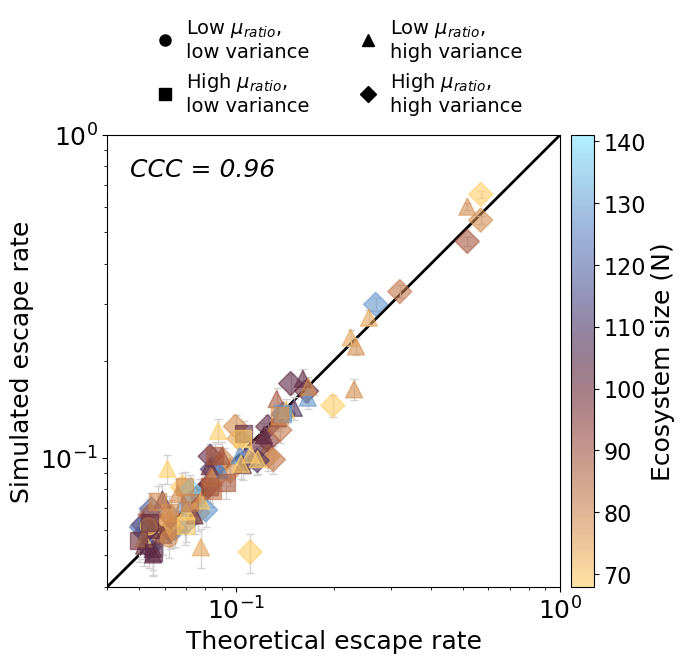

In [14]:
# Directory where the result files are saved
PARAM_DIR = 'parameterized_networks_local_stable_FW_1.3/'

#plotting funct again
def plot_all_ratios_loglog(data_points, output_filename="all_ratios_loglog_comparison_FW.png"):
    """
    Creates a log-log plot with error bars comparing escape rate ratios
    with their corresponding simulated loss ratios, using different markers.
    """
    if not data_points:
        print("No data points met the threshold for plotting.")
        return

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xscale('log')
    ax.set_yscale('log')

    markers = {
        'mur0.5_c0.5': ('o', r'Low $\mu_{ratio}$,' +'\n' + 'low variance'),
        'mur2.0_c0.5': ('s', r'High $\mu_{ratio}$,' +'\n' + 'low variance'),
        'mur0.5_c2.0': ('^', r'Low $\mu_{ratio}$,' +'\n' + 'high variance'),
        'mur2.0_c2.0': ('D', r'High $\mu_{ratio}$,' +'\n' + 'high variance')
    }

    #aggregate data
    all_analytical = np.concatenate([d['analytical'] for d in data_points.values()])
    all_simulated = np.concatenate([d['simulated'] for d in data_points.values()])
    # Perform linear regression on log transformed data
    if len(all_analytical) > 1:
        valid_indices = (all_analytical > 0) & (all_simulated > 0)
        log_analytical = np.log10(all_analytical[valid_indices])
        log_simulated = np.log10(all_simulated[valid_indices])
        
        slope, intercept, r_value, _, _ = linregress(log_analytical, log_simulated)
        r_squared = r_value**2
        rmse = np.sqrt(np.mean((log_simulated - log_analytical)**2))
        #CC coefficient
        ccc = concordance_correlation_coefficient(log_simulated, log_analytical)
    else:
        slope, intercept, r_squared, rmse, ccc = (np.nan,) * 5

    # Set fixed plot limits
    min_lim = 0.04
    max_lim = 1.0

    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim) 

    ax.plot([min_lim, max_lim], [min_lim, max_lim],
            color='black', linestyle='-', linewidth=2.0, zorder=1)

    all_sizes = np.concatenate([d['sizes'] for d in data_points.values()])
    norm = plt.Normalize(vmin=np.min(all_sizes), vmax=np.max(all_sizes))

    # plot data without labels
    for config_key, data in data_points.items():
        marker_shape, label = markers.get(config_key, ('x', config_key))
        
        ax.errorbar(
            data['analytical'], 
            data['simulated'],
            yerr=data['se'],
            fmt='none',
            ecolor='lightgray',
            elinewidth=1,
            capsize=3,
            zorder=5
        )

        scatter = ax.scatter(
            data['analytical'], 
            data['simulated'],
            c=data['sizes'],
            cmap='managua',
            marker=marker_shape,
            label=None,
            s=150, 
            alpha=0.6,
            norm=norm,
            zorder=10
        )

    # create dummy plots for legends
    for config_key in markers:
        marker_shape, label = markers[config_key]
        ax.plot([], [], # Empty data
                marker=marker_shape,
                color='black',
                linestyle='None',
                markersize=8,
                label=label)

    cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label("Ecosystem size (N)", fontsize=18)
    cbar.ax.tick_params(labelsize=16)
    ax.set_xlabel("Theoretical escape rate", fontsize=18)
    ax.set_ylabel("Simulated escape rate", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # create the legend from our clean dummy plots
    ax.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=False, labelspacing=0.5, handletextpad=0.1)

    #statistical results
    # stats_text = (f"log(y) = {slope:.2f}log(x) + {intercept:.2f}\n"
    #               f"$R^2$ = {r_squared:.2f} | RMSE = {rmse:.2f}\n"
    #               f"CCC (log-space) = {ccc:.2f}")
    stats_text = (f"CCC = {ccc:.2f}")
                  
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', fontweight='normal', fontstyle='oblique', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.0))
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    print(f"Plot saved as {output_filename}")
    plt.show()

# main execution
if __name__ == '__main__':
    escape_rate_threshold = 0.05
    loss_ratio_threshold = 0.05
    data_points = {}
    param_files = [f for f in os.listdir(PARAM_DIR) if f.endswith('.npz')]
    
    for file_name in param_files:
        parts = file_name.replace('.npz', '').split('_')
        mu_part = next((p for p in parts if p.startswith('mur')), None)
        c_part = next((p for p in parts if p.startswith('c')), None)

        if mu_part is None or c_part is None:
            continue
        
        config_key = f"{mu_part}_{c_part}"

        file_path = os.path.join(PARAM_DIR, file_name)
        data = np.load(file_path, allow_pickle=True)
        
        required_keys = ['analytical_escape_ratios', 'loss_frequencies', 'se_loss_frequencies', 'interaction_matrix_A0']
        if not all(key in data for key in required_keys):
            continue

        if config_key not in data_points:
            data_points[config_key] = {'analytical': [], 'simulated': [], 'se': [], 'sizes': []}

        analytical_ratios = data['analytical_escape_ratios']
        simulated_ratios = data['loss_frequencies']
        simulated_ratios_se = data['se_loss_frequencies']
        S = data['interaction_matrix_A0'].shape[0]
        
        for i in range(S):
            if analytical_ratios[i] > escape_rate_threshold and simulated_ratios[i] > loss_ratio_threshold:
                data_points[config_key]['analytical'].append(analytical_ratios[i])
                data_points[config_key]['simulated'].append(simulated_ratios[i])
                data_points[config_key]['se'].append(simulated_ratios_se[i])
                data_points[config_key]['sizes'].append(S)

    for config in data_points:
        for key in data_points[config]:
            if data_points[config][key]:
                 data_points[config][key] = np.array(data_points[config][key])

    data_points_filtered = {k: v for k, v in data_points.items() if len(v['analytical']) > 0}
    plot_all_ratios_loglog(data_points_filtered)

### For a single ecosystem analyze the escape rate predictions of species

Successfully loaded data from M_SD_024_mur2.0_c0.5.npz
Applying robust pyramid sort to species based on escape rates...
Plot saved as 'ratio_comparison_pyramid_M_SD_024_mur2.0_c0.5.png'


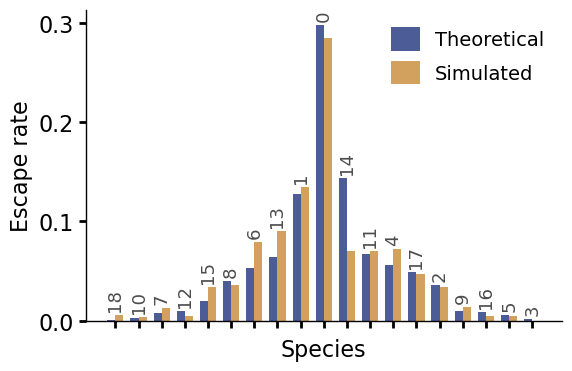

In [16]:
def plot_single_network_comparison(network_filename, data_dir, save_filename="figures/single_network_ratio_comparison.png"):
    """
    Loads data for a single network and plots a bar chart comparing the
    analytical 'Escape Rate Ratios' and the Monte Carlo 'Loss Ratios'.
    Species are reordered, and their original indices are plotted above the bars.
    """
    file_path = os.path.join(data_dir, network_filename)

    # --- 1. Load Data ---
    try:
        data = np.load(file_path, allow_pickle=True)
        print(f"Successfully loaded data from {network_filename}")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- 2. Extract Necessary Data for Plotting ---
    escape_ratios = data.get('analytical_escape_ratios')
    loss_ratios = data.get('loss_frequencies')
    
    if escape_ratios is None or loss_ratios is None:
        print(f"Error: The file '{network_filename}' is missing required data arrays.")
        return

    S = len(escape_ratios)
    
    # --- 3. Set up the Plot Elements with Custom Sorting ---
    print("Applying robust pyramid sort to species based on escape rates...")

    # 1. Get the indices sorted by escape_ratios in descending order
    desc_sort_indices = np.argsort(escape_ratios)[::-1]

    # 2. Build the pyramid order using array slicing
    peak_idx = desc_sort_indices[0]
    right_indices = desc_sort_indices[1::2]
    left_indices = desc_sort_indices[2::2][::-1]

    # 3. Concatenate to get the final, correct pyramid order.
    pyramid_order_indices = np.concatenate((left_indices, [peak_idx], right_indices))
    
    # 4. Apply this new "pyramid" order to the data before plotting
    escape_ratios = escape_ratios[pyramid_order_indices]
    loss_ratios = loss_ratios[pyramid_order_indices]

    species_indices = np.arange(S)
    bar_width = 0.35
    
    # Set plotting style
    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 16, 'axes.labelsize': 16, 'axes.titlesize': 16,
        'xtick.labelsize': 16, 'ytick.labelsize': 16, 'legend.fontsize': 14,
        'axes.linewidth': 1,
    })

    fig, ax = plt.subplots(figsize=(6, 4))

    # --- 4. Plot the Grouped Bars (now in correct pyramid order) ---
    color_escape = '#4c5c96'
    color_loss = '#d1a15d'
    
    ax.bar(species_indices - bar_width/2, escape_ratios, bar_width, 
           label='Theoretical', color=color_escape)
    ax.bar(species_indices + bar_width/2, loss_ratios, bar_width, 
           label='Simulated', color=color_loss)

    # --- 5. Style and Finalize the Plot ---
    for i in range(S):
        # The original index of the species being plotted at this position
        original_species_index = pyramid_order_indices[i]
        
        # Find the top of the taller bar for this species pair
        bar_height = max(escape_ratios[i], loss_ratios[i]) + 0.004
        
        # Place the text label just above the taller bar
        ax.text(x=species_indices[i], 
                y=bar_height,  # Position text at the top of the bar
                s=f'{original_species_index}', # The text to display
                ha='center',      # Horizontal alignment
                va='bottom',      # Vertical alignment places bottom of text at y coordinate
                fontsize=13,       # Use a small font size to avoid clutter
                color='black',
                alpha=0.7,
                rotation=90,      # Rotate for better readability
                #fontweight='bold',
                #family='monospace'
                )
    
    ax.set_ylabel('Escape rate')
    ax.set_xlabel('Species')
    
    title_name = os.path.splitext(network_filename)[0].split('_mur')[0]
    
    ax.set_xticks(species_indices)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', length=5, width=2)
    ax.tick_params(axis='y', width=2, length=5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.legend(frameon = False, handleheight = 1.5, handlelength = 1.5)
    fig.tight_layout()

    # --- 6. Save and Show ---
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved as '{save_filename}'")
    plt.show()

# --- Main Execution Block for This Cell ---
TARGET_NETWORK_DIR = 'single_network_analysis/'
TARGET_FILENAME = "M_SD_024_mur2.0_c0.5.npz" 

if os.path.exists(TARGET_NETWORK_DIR):
    if TARGET_FILENAME is None:
        print("No specific file provided. Searching for the first available processed file...")
        processed_files = [
            f for f in os.listdir(TARGET_NETWORK_DIR)
            if f.endswith('.npz') and 'loss_frequencies' in np.load(os.path.join(TARGET_NETWORK_DIR, f))
        ]
        if processed_files:
            TARGET_FILENAME = processed_files[0]
        else:
            print("Could not find any fully processed network files.")
            TARGET_FILENAME = None

    if TARGET_FILENAME:
        if os.path.exists(os.path.join(TARGET_NETWORK_DIR, TARGET_FILENAME)):
            output_plot_name = f"ratio_comparison_pyramid_{os.path.splitext(TARGET_FILENAME)[0]}.png"
            plot_single_network_comparison(
                network_filename=TARGET_FILENAME,
                data_dir=TARGET_NETWORK_DIR,
                save_filename=output_plot_name
            )
        else:
            print(f"\nError: The specified file '{TARGET_FILENAME}' does not exist.")
else:
    print(f"Error: Data directory '{TARGET_NETWORK_DIR}' not found.")


### Draw network diagram of the above ecosystem

Successfully loaded interaction matrix from M_SD_024_mur2.0_c0.5.npz
Calculating Custom Curved layout...

Network diagram saved as 'network_diagram_M_SD_024_mur2.0_c0.5.png'


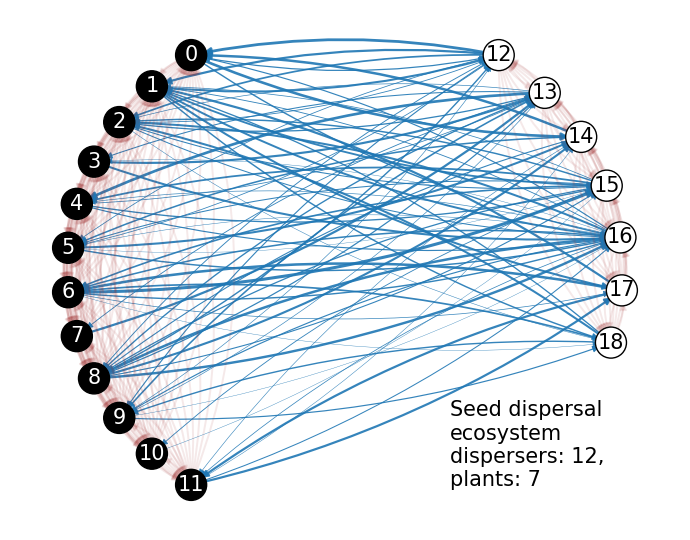

In [15]:
def draw_network_diagram(network_filename, param_dir, original_data_dir, save_filename="network_diagram.png"):
    """
    Loads a parameterized network and draws its interaction diagram using a
    Custom 'Parenthesis' (Curved Bipartite) Layout.
    """
    param_file_path = os.path.join(param_dir, network_filename)

    # --- 1. Load Data ---
    try:
        data = np.load(param_file_path, allow_pickle=True)
        A0 = data['interaction_matrix_A0']
        print(f"Successfully loaded interaction matrix from {network_filename}")
    except FileNotFoundError:
        print(f"Error: The file '{param_file_path}' was not found.")
        return

    # --- 2. Create Graph from Interaction Matrix ---
    A_viz = A0.copy()
    np.fill_diagonal(A_viz, 0)
    G = nx.from_numpy_array(A_viz.T, create_using=nx.DiGraph())

    # --- 2.5 Identify Groups ---
    group1_nodes, group2_nodes = [], []
    base_name = os.path.splitext(network_filename)[0].split('_mur')[0]
    original_csv_path = os.path.join(original_data_dir, f"{base_name}.csv")

    if base_name.startswith(('M_', 'A_')) and os.path.exists(original_csv_path):
        L = pd.read_csv(original_csv_path, header=None).to_numpy()
        n_rows, n_cols = L.shape
        group1_nodes = list(range(n_rows))
        group2_nodes = list(range(n_rows, G.number_of_nodes()))
    else:
        n = G.number_of_nodes()
        group1_nodes = list(range(n // 2))
        group2_nodes = list(range(n // 2, n))

    # --- 3. Calculate Layout (Custom Curved/C-Shaped) ---
    print("Calculating Custom Curved layout...")
    pos = {}
    
    # Define aesthetics for the curves
    radius = 10         # Radius of the arc
    center_gap = 4      # Distance between the two curves
    
    # Function to distribute nodes along an arc
    def place_nodes_on_arc(nodes, start_angle, end_angle, x_offset):
        if len(nodes) > 1:
            # Create evenly spaced angles
            angles = np.linspace(start_angle, end_angle, len(nodes))
        else:
            angles = [ (start_angle + end_angle) / 2 ]
            
        for i, node in enumerate(nodes):
            theta = np.radians(angles[i])
            # Polar to Cartesian conversion
            x = radius * np.cos(theta) + x_offset
            y = radius * np.sin(theta)
            pos[node] = np.array([x, y])

    # Group 1 (Left side): Curve bulging to the left (like '(' )
    # Angles: 130 to 230 degrees places them on the left semi-circle
    place_nodes_on_arc(group1_nodes, 130, 230, x_offset=center_gap/2)

    # Group 2 (Right side): Curve bulging to the right (like ')' )
    # Angles: 50 to -50 degrees places them on the right semi-circle
    place_nodes_on_arc(group2_nodes, 50, -15, x_offset=-center_gap/2)

    # --- 4. Define Styles ---
    node_colors = ["#000000"] * len(group1_nodes) + ["#FFFFFF"] * len(group2_nodes)
    
    in_group_edges, between_group_edges = [], []
    in_group_widths, between_group_widths = [], []
    max_abs_weight = np.max(np.abs(A_viz)) if A_viz.size > 0 else 1.0

    for u, v in G.edges():
        weight = G[u][v]['weight']
        width = 2.0 * (abs(weight) / max_abs_weight) + 0.2
        is_ingroup = (u in group1_nodes and v in group1_nodes) or \
                     (u in group2_nodes and v in group2_nodes)
        if is_ingroup:
            in_group_edges.append((u, v))
            in_group_widths.append(width)
        else:
            between_group_edges.append((u, v))
            between_group_widths.append(width)

    # --- 5. Draw the Network ---
    plt.style.use('default')
    # Taller figure to accommodate the vertical arcs
    fig, ax = plt.subplots(figsize=(7, 5.5)) 
    
    # Draw Nodes (Smaller size: 300)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, 
                           alpha=1.0, edgecolors='black', linewidths=1.0)
    
    # Draw Edges with a slight arc (rad=0.1) for elegance
    nx.draw_networkx_edges(G, pos, edgelist=between_group_edges, edge_color='#1f77b4', 
                           width=between_group_widths, alpha=0.9, arrowsize=10, 
                           connectionstyle="arc3,rad=0.1")
                           
    nx.draw_networkx_edges(G, pos, edgelist=in_group_edges, edge_color="#a02d2d", 
                           width=in_group_widths, alpha=0.1, arrowsize=10, 
                           connectionstyle="arc3,rad=0.2")

    labels1 = {node: str(node) for node in group1_nodes}
    labels2 = {node: str(node) for node in group2_nodes}
    
    # Offset labels slightly so they don't overlap the nodes on the curve
    # (Optional visual tweak, but standard labels usually work okay)
    nx.draw_networkx_labels(G, pos, labels=labels1, font_size=15, font_color='white')
    nx.draw_networkx_labels(G, pos, labels=labels2, font_size=15, font_color='black')

    # Text Box Styling (Moved to Bottom Left to avoid collision)
    info_text = (f"Seed dispersal\necosystem\n"
                 f"dispersers: {len(group1_nodes)},\nplants: {len(group2_nodes)}")
    
    fig.text(0.65, 0.1, info_text,
             fontsize=15,
             ha='left',
             va='bottom',
             bbox=dict(boxstyle='square,pad=0.2', fc='black', alpha=0.00))

    # Adjust layout to ensure nothing is clipped
    plt.tight_layout() 
    plt.axis('off')

    # --- 6. Save and Show ---
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    print(f"\nNetwork diagram saved as '{save_filename}'")
    plt.show()

# --- Main Execution Block ---
PARAM_DIR = 'single_network_analysis/'
ORIGINAL_DATA_DIR = 'web-of-life_2025/'
TARGET_FILENAME = "M_SD_024_mur2.0_c0.5.npz"

if TARGET_FILENAME:
    output_plot_name = f"network_diagram_{os.path.splitext(TARGET_FILENAME)[0]}.png"
    draw_network_diagram(
        network_filename=TARGET_FILENAME,
        param_dir=PARAM_DIR,
        original_data_dir=ORIGINAL_DATA_DIR,
        save_filename=output_plot_name
    )